These analysis are based on https://cran.r-project.org/web/packages/VARsignR/vignettes/VARsignR-vignette.html#fnref2

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from statsmodels.tsa.vector_ar import var_model as sm
import numpy as np
from math import sqrt
from statsmodels.tsa.vector_ar import util

E:\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


first we need a pure cholesky decomposition version

In [2]:
data = pd.read_csv("test_data.csv", index_col=0)
lags = 1

In [3]:
var = sm.VAR(endog=data.values)

first estimate unrestricted VAR, then distract A_td and sigma_td from the regression result, where  
$$\Sigma = E[uu^T]$$
$$u = Be$$
$$BB^T = \Sigma$$

In [6]:
result = var.fit(maxlags=lags, trend="nc")
p, k = result.coefs.shape[0], result.coefs.shape[1]
A_1 = result.coefs[0]
sigma = result.sigma_u

for estimating VAR(p), we have to write the estimation ourselves

Then we use a cholesky decomposition to generate uncorrelated innovations, notice that we are not using the decomposition matrix as an ordering, but just to generate uncorrelated innovations, namely P

In [7]:
P = np.linalg.cholesky(sigma)
diag = np.diag(P)
D = np.eye(len(P)) * P
A = D.dot(np.linalg.inv(P))

A_star = A.dot(A_1)

So the innovations according to the cholesky decomposition should be  
following Uhlig’s(2005) rejection method, we draw impulse vector a from unit sphere

In [8]:
def get_sphere_rand(larger_c, less_c):
    while True:
        trand = np.random.rand(len(sigma)) - 0.5
        tt = trand / sqrt(sum(trand**2))
        if (tt[larger_c] > 0.0).all() and (tt[less_c] < 0.0).all():
            return tt

Then we start the restricted impulse reponse analysis

In [9]:
MAX_COUNT = 2e5

In [10]:
count = 0
'''
larger_constraints = np.array([True, True, True, True, False, False, False, False])
less_constraints = np.array([False, False, False, False, True, True, True, True])
larger_c = np.array([False, False, False, False, False, False, False, False])
less_c = np.array([False, False, False, False, False, False, False, False])
'''

larger_constraints = np.array([True, True, False, False])
less_constraints = np.array([False, False, True, True])
larger_c = np.array([False, False, False, False])
less_c = np.array([False, False, False, False])

impulse_count = 6
draw_count = 20
# TODO: the restriction can only have effect for several period
# TODO: how to calculate in VAR(p)?

impulse_matrix = np.zeros((draw_count, A.shape[0], impulse_count))
a = None
A_tt = np.linalg.inv((np.eye(len(A_star)) - A_star)).dot(A_star)
for j in xrange(draw_count):
    i = 0
    a = get_sphere_rand(larger_c, less_c)
    print j
    while True:
        if i == impulse_count:
            break
        A_tmp = A_tt**(i + 1)
        t_impulse = A_tmp.dot(a)
        if (t_impulse[larger_constraints] > 0.0).all() and (t_impulse[less_constraints] < 0.0).all():
            impulse_matrix[j, :, i] = t_impulse
            i += 1
        else:
            a = get_sphere_rand(larger_constraints, less_constraints)
            i = 0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


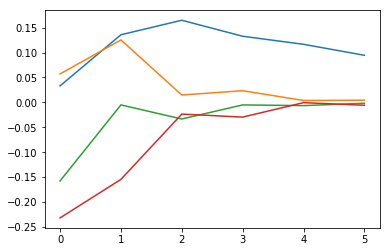

In [11]:
plt.plot(impulse_matrix.mean(0)[0, :])
plt.plot(impulse_matrix.mean(0)[1, :])
plt.plot(impulse_matrix.mean(0)[2, :])
plt.plot(impulse_matrix.mean(0)[3, :])

#std = impulse_matrix.std(0)[1, :]
#plt.plot(mean - 3*std)
#plt.plot(mean + 3*std)

here is a VAR(p) version

In [12]:
y = util.get_var_endog(data.values, lags=2, trend="nc")

In [13]:
var2 = sm.VAR(endog=y)

In [14]:
result = var2.fit(maxlags=lags, trend="nc")
p, k = result.coefs.shape[0], result.coefs.shape[1]
A_1 = result.coefs[0]
sigma = result.sigma_u

In [15]:
P = np.linalg.cholesky(sigma)
diag = np.diag(P)
D = np.eye(len(P)) * P
A = D.dot(np.linalg.inv(P))

A_star = A.dot(A_1)

In [ ]:
count = 0

larger_constraints = np.array([True, True, True, True, False, False, False, False])
less_constraints = np.array([False, False, False, False, True, True, True, True])
larger_c = np.array([False, False, False, False, False, False, False, False])
less_c = np.array([False, False, False, False, False, False, False, False])

'''
larger_constraints = np.array([True, True, False, False])
less_constraints = np.array([False, False, True, True])
larger_c = np.array([False, False, False, False])
less_c = np.array([False, False, False, False])
'''
impulse_count = 2
draw_count = 2
# TODO: the restriction can only have effect for several period
# TODO: how to calculate in VAR(p)?

impulse_matrix = np.zeros((draw_count, A.shape[0], impulse_count))
a = None
A_tt = np.linalg.inv((np.eye(len(A_star)) - A_star)).dot(A_star)
for j in xrange(draw_count):
    i = 0
    a = get_sphere_rand(larger_c, less_c)
    print j
    while True:
        if i == impulse_count:
            break
        A_tmp = A_tt**(i + 1)
        t_impulse = A_tmp.dot(a)
        if (t_impulse[larger_constraints] > 0.0).all() and (t_impulse[less_constraints] < 0.0).all():
            impulse_matrix[j, :, i] = t_impulse
            i += 1
        else:
            a = get_sphere_rand(larger_constraints, less_constraints)
            i = 0

0
